In [1]:
import os
import subprocess
import random
import warnings
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import unitary_group
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm.notebook import tqdm
import itertools

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

%load_ext autoreload
%autoreload 2

In [2]:
with open('./params_setting.yaml', 'r') as yml:
    params = yaml.safe_load(yml)
    
# quantum circuit parameter
n_qubit = params["circuit_info"]["n_qubit"]
each_n_shot = params["circuit_info"]["each_n_shot"]
state_name = params["circuit_info"]["state_name"]
error_model = params["circuit_info"]["error_model"]
error_rate = params["circuit_info"]["error_rate"]

# RBM architecture parameter
n_visible_unit = params["architecture_info"]["n_visible_unit"]
n_hidden_unit = params["architecture_info"]["n_hidden_unit"] 
n_aux_unit = params["architecture_info"]["n_aux_unit"]

# train parameter
lr = params["train_info"]["lr"]
pbs = params["train_info"]["positive_batch_size"]
nbs = params["train_info"]["negative_batch_size"]
n_gibbs_step = params["train_info"]["n_gibbs_step"]
period = 1
epoch = params["train_info"]["n_epoch"]
lr_drop_epoch = params["train_info"]["lr_drop_epoch"]
lr_drop_factor = params["train_info"]["lr_drop_factor"]
seed = params["train_info"]["seed"]

# sampling parameter
n_sampling = params["sampling_info"]["n_sample"]
n_copy = params["sampling_info"]["n_copy"]

# data path info
environment = "local"
if environment == "local":
    train_data_path = f"./data/{error_model}/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/"
    target_state_path = f"./target_state/{error_model}/error_rate_{100*error_rate}%/"
    model_path = f"./model/{error_model}/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/"
    train_log_path = f"./train_log/{error_model}/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/"
if environment == "colab":
    from google.colab import drive
    drive.mount("/content/drive/")
    drive_path = "/content/drive/MyDrive/NQS4QEM/2-qubit_random_unitary"
    train_data_path = drive_path + f"/data/{error_model}/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/"
    target_state_path = drive_path + f"/target_state/{error_model}/error_rate_{100*error_rate}%/"
    model_path = drive_path + f"/model_dm/{error_model}/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/"
    train_log_path = drive_path + f"/train_log/{error_model}/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/"

# settings
## warnings
warnings.simplefilter('ignore')

## seaborn layout
sns.set()
sns.set_style("white")

## seed
def seed_settings(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    qucumber.set_random_seed(seed, cpu=True, gpu=False)

seed_settings(seed=seed)

## utils

In [3]:
def get_density_matrix(nn_state):
    space = nn_state.generate_hilbert_space()
    Z = nn_state.normalization(space)
    tensor = nn_state.rho(space, space)/Z
    tensor = cplx.conjugate(tensor)
    matrix = cplx.numpy(tensor)
    return matrix

def get_max_eigvec(matrix):
    e_val, e_vec = np.linalg.eigh(matrix)
    me_val = e_val[-1]
    me_vec = e_vec[:,-1]
    return me_vec

def get_eigvec(nn_state, obs, space, **kwargs):
    dm = get_density_matrix(nn_state)
    ev = get_max_eigvec(dm)
    ev = np.atleast_2d(ev)
    val = ev@obs@ev.T.conj()
    val = val[0,0].real
    return val

def fidelity(state_1, state_2):
    F = np.trace(sqrtm(sqrtm(state_1)@state_2@sqrtm(state_1)))
    return (F.real)**2

## Rx gate
def Rx(n_qubit, target_qubit_idx, theta):
    I = np.eye(2)
    local_Rx = np.array([[np.cos(theta/2),-1j*np.sin(theta/2)], [-1j*np.sin(theta/2),np.cos(theta/2)]])
    if target_qubit_idx==0:
        mat = local_Rx
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_Rx)
        else:
            mat = np.kron(mat, I)
            
    return mat

## Ry gate
def Ry(n_qubit, target_qubit_idx, theta):
    I = np.eye(2)
    local_Ry = np.array([[np.cos(theta/2),-np.sin(theta/2)], [-np.sin(theta/2),np.cos(theta/2)]])
    if target_qubit_idx==0:
        mat = local_Ry
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_Ry)
        else:
            mat = np.kron(mat, I)
            
    return mat

## Rz gate
def Rz(n_qubit, target_qubit_idx, theta):
    I = np.eye(2)
    local_Rz = np.array([[np.exp(-1j*theta/2),0], [0,np.cos(1j*theta/2)]])
    if target_qubit_idx==0:
        mat = local_Rz
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_Rz)
        else:
            mat = np.kron(mat, I)
            
    return mat

def global_depolarizing(state, n_qubit, error_rate):
    return (1-error_rate)*state + error_rate*np.trace(state)*np.eye(2**n_qubit)/(2**n_qubit)
    
def unitary(state, n_qubit, theta, target_qubit_idx):
    return Rx(n_qubit, target_qubit_idx, theta) @ state @ Rx(n_qubit, target_qubit_idx, theta).T.conjugate()

def init_state(n_qubit, state_name):
    ket_0 = np.array([[1],[0]]) 
    init_state = ket_0
    
    for i in range(2**(n_qubit-1)-1):
        init_state = np.append(init_state, np.array([[0],[0]]), axis=0) # |00...0>
    
    if state_name == "density_matrix":
        init_state_vec = init_state
        init_state = init_state_vec @ init_state_vec.T.conjugate() # |00...0><00...0|
    
    return init_state

## target quantum circuit

In [4]:
def Random_unitary(n_qubit, state_name, error_model, error_rate):
    from scipy.stats import unitary_group
    U = unitary_group.rvs(dim = 2**n_qubit, random_state = seed)
    
    if state_name == "state_vector":
        if error_model == "ideal":
            state = init_state(n_qubit, state_name)
            state = U @ state
            
    if state_name == "density_matrix":
        if error_model == "ideal":
            state = init_state(n_qubit, state_name)
            state = U @ state @ U.T.conjugate()
        
        if error_model == "depolarizing":
            state = init_state(n_qubit, state_name)
            state = U @ state @ U.T.conjugate()
            state = global_depolarizing(state, n_qubit, error_rate)
        
        if error_model == "unitary":
            state = init_state(n_qubit, state_name)
            state = U @ state @ U.T.conjugate()
            for i in range(n_qubit):
                state = unitary(state, n_qubit, np.sqrt(error_rate), i)
            
        if error_model == "depolarizing&unitary":
            state = init_state(n_qubit, state_name)
            state = U @ state @ U.T.conjugate()
            state = global_depolarizing(state, n_qubit, error_rate)
            for i in range(n_qubit):
                state = unitary(state, n_qubit, np.sqrt(error_rate), i)
    
    return state

### depolarizing error

In [5]:
# load train log
train_log_dep_df = pd.read_csv(f"./train_log/depolarizing/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/train_log.csv")

ideal_state = Random_unitary(n_qubit, state_name, "ideal", error_rate)
noisy_state = Random_unitary(n_qubit, state_name, "depolarizing", error_rate)
ideal_noisy_fidelity = fidelity(ideal_state, noisy_state)

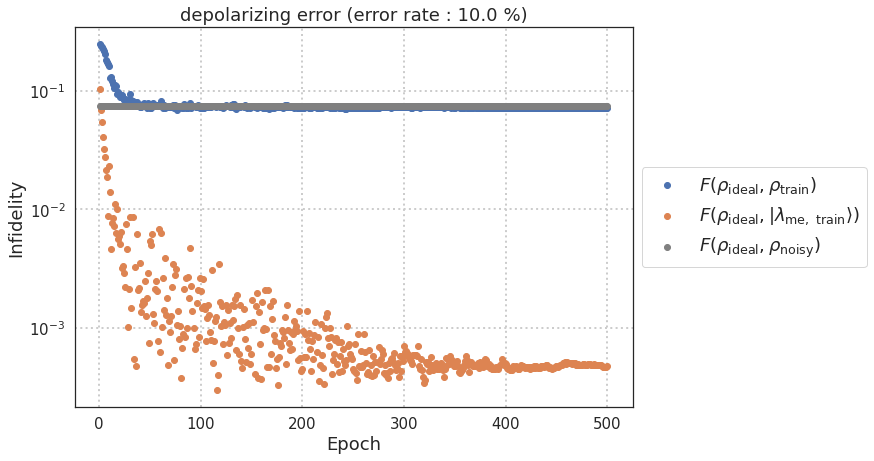

In [6]:
x = train_log_dep_df["epoch"].values
tick_label = np.arange(1, 501).astype("str")
labels = [r"$F(\rho_{\rm ideal}, \rho_{\rm train})$", 
          #r"$F(\rho_{\rm noisy}, \rho_{\rm train})$", 
          r"$F(\rho_{\rm ideal}, | \lambda_{\rm me,\ train} \rangle)$",
          r"$F(\rho_{\rm ideal}, \rho_{\rm noisy})$"]

plt.figure(figsize=(10, 7))
plt.scatter(x, 1-train_log_dep_df["ideal_fidelity"].values)
#plt.scatter(x, 1-train_log_dep_df["noisy_fidelity"].values)
plt.scatter(x, 1-train_log_dep_df["max_eigen_fidelity"].values)
plt.scatter(x, 1-np.repeat(ideal_noisy_fidelity, 500), c = "grey")

plt.title(f'depolarizing error (error rate : {error_rate*100} %)', fontsize=18)
plt.yscale('log')
plt.xlabel("Epoch", fontsize=18)
plt.ylabel('Infidelity', fontsize=18)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=18)
#plt.savefig("./figures/fidelity_depolarizing.pdf", bbox_inches='tight')

### unitary error

In [7]:
# load train log
train_log_uni_df = pd.read_csv(f"./train_log/unitary/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/train_log.csv")

ideal_state = Random_unitary(n_qubit, state_name, "ideal", error_rate)
noisy_state = Random_unitary(n_qubit, state_name, "unitary", error_rate)
ideal_noisy_fidelity = fidelity(ideal_state, noisy_state)

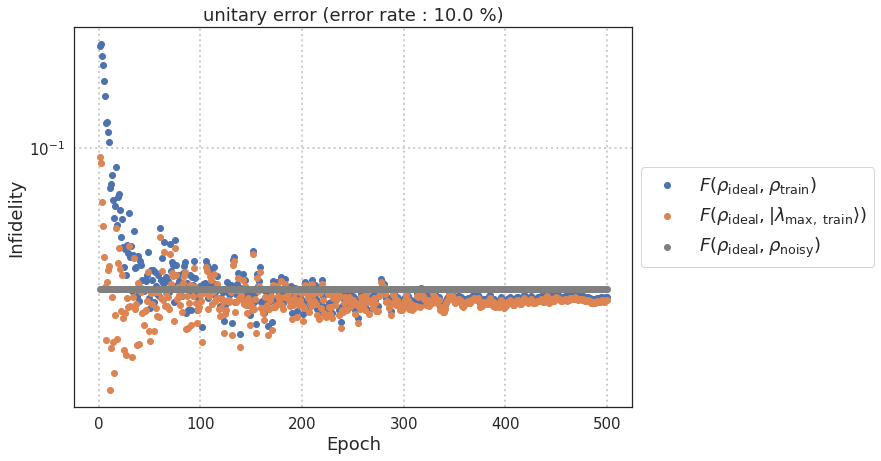

In [8]:
x = train_log_uni_df["epoch"].values
tick_label = np.arange(1, 501).astype("str")
labels = [r"$F(\rho_{\rm ideal}, \rho_{\rm train})$", 
          #r"$F(\rho_{\rm noisy}, \rho_{\rm train})$", 
          r"$F(\rho_{\rm ideal}, | \lambda_{\rm max,\ train} \rangle)$",
          r"$F(\rho_{\rm ideal}, \rho_{\rm noisy})$"]

plt.figure(figsize=(10, 7))
plt.scatter(x, 1-train_log_uni_df["ideal_fidelity"].values)
#plt.scatter(x, 1-train_log_uni_df["noisy_fidelity"].values)
plt.scatter(x, 1-train_log_uni_df["max_eigen_fidelity"].values)
plt.scatter(x, 1-np.repeat(ideal_noisy_fidelity, 500), c = "grey")

plt.title(f'unitary error (error rate : {error_rate*100} %)', fontsize=18)
plt.yscale('log')
plt.xlabel("Epoch", fontsize=18)
plt.ylabel('Infidelity', fontsize=18)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=18)
#plt.savefig("./figures/fidelity_depolarizing.pdf", bbox_inches='tight')

### depolarizing error & unitary error

In [9]:
# load train log
train_log_uni_df = pd.read_csv(f"./train_log/depolarizing&unitary/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/train_log.csv")

ideal_state = Random_unitary(n_qubit, state_name, "ideal", error_rate)
noisy_state = Random_unitary(n_qubit, state_name, "depolarizing&unitary", error_rate)
ideal_noisy_fidelity = fidelity(ideal_state, noisy_state)

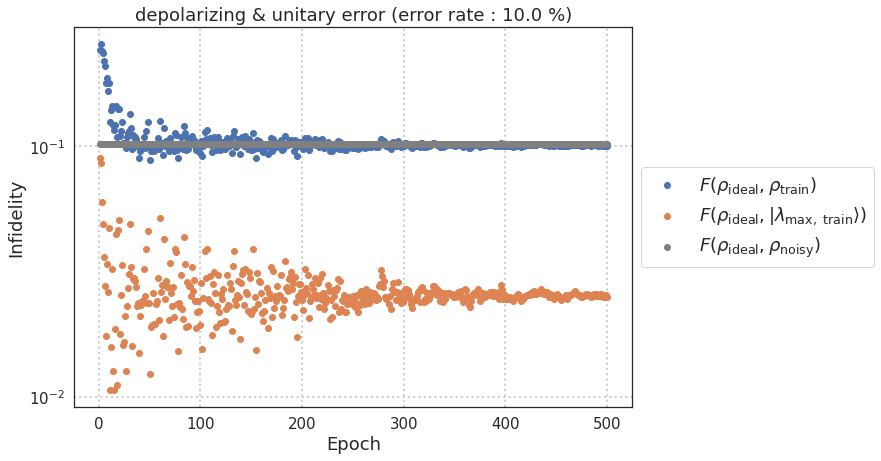

In [10]:
x = train_log_uni_df["epoch"].values
tick_label = np.arange(1, 501).astype("str")
labels = [r"$F(\rho_{\rm ideal}, \rho_{\rm train})$", 
          #r"$F(\rho_{\rm noisy}, \rho_{\rm train})$", 
          r"$F(\rho_{\rm ideal}, | \lambda_{\rm max,\ train} \rangle)$",
          r"$F(\rho_{\rm ideal}, \rho_{\rm noisy})$"]

plt.figure(figsize=(10, 7))
plt.scatter(x, 1-train_log_uni_df["ideal_fidelity"].values)
#plt.scatter(x, 1-train_log_uni_df["noisy_fidelity"].values)
plt.scatter(x, 1-train_log_uni_df["max_eigen_fidelity"].values)
plt.scatter(x, 1-np.repeat(ideal_noisy_fidelity, 500), c = "grey")

plt.title(f'depolarizing & unitary error (error rate : {error_rate*100} %)', fontsize=18)
plt.yscale('log')
plt.xlabel("Epoch", fontsize=18)
plt.ylabel('Infidelity', fontsize=18)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=18)
#plt.savefig("./figures/fidelity_depolarizing.pdf", bbox_inches='tight')